Анализ качества поиска релевантных фрагментов базы знаний, соответствующих вопросу

In [ ]:
!pip install openai langchain==0.0.262 faiss-cpu tiktoken nltk==3.8.1 InstructorEmbedding==1.0.1
!pip install -U deep-translator==1.11.4
!pip install --force --no-deps git+https://github.com/UKPLab/sentence-transformers.git
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.1.77 --force-reinstall --upgrade --no-cache-dir

In [ ]:
import gdown
import tiktoken
import pickle
import tqdm
import pandas as pd
from deep_translator import GoogleTranslator
from langchain.document_loaders import TextLoader
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter

TOTAL_AMOUNT = 0

In [ ]:
def load_googledoc(url, path):
    id = url.split('/')[-2]
    gdown.download(f'https://drive.google.com/uc?export=download&id={id}', path)


# Подсчет токенов
def num_tokens_from_string(string: str, encoding_name: str) -> int:
    encoding = tiktoken.get_encoding(encoding_name)
    return len(encoding.encode(string))


# количество токенов индексной базы и стоимость. model Ada v2
def tokens_count_db(source_chunks):
    global TOTAL_AMOUNT
    count_tokens = 0
    count_token = num_tokens_from_string(' '.join([x.page_content for x in source_chunks]), "cl100k_base")
    count_tokens += count_token
    print(f'Количество токенов в документе: {count_token}')
    # Embedding model Ada v2 - $0.00010 / 1K tokens - 28/02/2024 - https://openai.com/pricing
    price = 0.0001 * count_tokens / 1000
    TOTAL_AMOUNT += price
    print(f'ЦЕНА создания индексной базы: $ {price}')

In [ ]:
#@title Чанки на русском

# База знаний УИИ:
url = 'https://drive.google.com/file/d/1-gRMM-kX0WbCwFWzSr-6mvj-HZx9tGFf/view?usp=sharing '
load_googledoc(url, 'knowledge_base.txt')

loader = TextLoader("/content/knowledge_base.txt")
documents = loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=0)
docs = text_splitter.split_documents(documents)
tokens_count_db(docs) # Количество токенов и цена, если OpenAIEmbeddings

# Текстовые чанки на русском
with open('docs_ru.pkl', "wb") as file:
    pickle.dump(docs, file)
len(docs)

Downloading...
From: https://drive.google.com/uc?export=download&id=1-gRMM-kX0WbCwFWzSr-6mvj-HZx9tGFf
To: /content/knowledge_base.txt
100%|██████████| 1.24M/1.24M [00:00<00:00, 139MB/s]


Количество токенов в документе: 273794
ЦЕНА создания индексной базы: $ 0.0273794


2157

In [ ]:
#@title Чанки на английском

with open('docs_ru.pkl', "rb") as file:
    docs = pickle.load(file)

docs_translate = []
for doc in tqdm.tqdm(docs): # Из русскоязычных чанков
    docs_translate.append(Document(page_content=GoogleTranslator(source='ru', target='en').\
                                   translate(doc.page_content)))
tokens_count_db(docs_translate) # Количество токенов и цена, если OpenAIEmbeddings

# Текстовые чанки на английском
with open('docs_en.pkl', "wb") as file:
    pickle.dump(docs_translate, file)

100%|██████████| 2157/2157 [30:47<00:00,  1.17it/s]


Количество токенов в документе: 133424
ЦЕНА создания индексной базы: $ 0.0133424


In [ ]:
#@title Вопросы
pd.read_csv("/content/Вопросы.csv", delimiter='/n')

<ipython-input-7-7442c2dc60a1>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv("/content/Вопросы.csv", delimiter='/n')


,Вопрос
0,Какие варианты рассрочки есть на тариф Основной?
1,Какие курсы по chatGPT есть в УИИ?
2,Какой документ будет по окончанию образования?
3,"""Можно ли купить стажировки, если я не являюсь..."
4,Несовершеннолетний ребенок может проходить обу...
5,Нужно ли мне покупать видеокарту для занятий?
6,Расскажите про курс AutoML
7,Что значит гарантия трудоустройства?


In [ ]:
#@title Русский на "multilingual-e5-large"

!git lfs install
!git clone https://huggingface.co/intfloat/multilingual-e5-large

Git LFS initialized.
Cloning into 'multilingual-e5-large'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 50 (delta 4), reused 0 (delta 0), pack-reused 41
Unpacking objects: 100% (50/50), 53.52 KiB | 1.49 MiB/s, done.
Filtering content: 100% (8/8), 6.29 GiB | 49.67 MiB/s, done.


In [ ]:
import pickle
import pandas as pd
from langchain.embeddings.sentence_transformer import SentenceTransformerEmbeddings
from langchain.vectorstores import FAISS
import os
import re


df_qw = pd.read_csv("/content/Вопросы.csv", delimiter='/n') # Вопросы

with open('docs_ru.pkl', "rb") as file:
    docs = pickle.load(file) # Русскоязычные чанки

project_path = ""
models = ["multilingual-e5-large"]

for model in models:
    history = []
    embeddings = SentenceTransformerEmbeddings(model_name=model)
    db = FAISS.from_documents(docs, embeddings)
    db.save_local(folder_path='', index_name='db_ru_multilingual-e5-large')

    for query in df_qw['Вопрос'].values:
        sim_docs = db.similarity_search_with_score(query)
        doc = re.sub(r'\n{2}', ' ', '\n '.join([f'Отрывок №{i+1}:\n' + \
                     doc[0].page_content + '\n' for i, doc in enumerate(sim_docs)]))
        history.append([str(query), str(doc)])

    pd.DataFrame(history, columns=['Вопрос', 'Отрывки']).\
    to_csv(os.path.join(project_path, os.path.split(model)[1]+'.csv'), index=False)

In [ ]:
#@title Английский "gte-large" и "bge-large-en-v1.5"

!git lfs install
!git clone https://huggingface.co/thenlper/gte-large
!git clone https://huggingface.co/BAAI/bge-large-en-v1.5

Git LFS initialized.
Cloning into 'gte-large'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 65 (delta 0), reused 0 (delta 0), pack-reused 62
Unpacking objects: 100% (65/65), 345.12 KiB | 4.73 MiB/s, done.
Filtering content: 100% (3/3), 2.49 GiB | 50.23 MiB/s, done.
Cloning into 'bge-large-en-v1.5'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 55 (delta 4), reused 0 (delta 0), pack-reused 43
Unpacking objects: 100% (55/55), 368.22 KiB | 3.76 MiB/s, done.
Filtering content: 100% (3/3), 3.74 GiB | 49.00 MiB/s, done.


In [ ]:
import pickle
import pandas as pd
from langchain.embeddings.sentence_transformer import SentenceTransformerEmbeddings
from langchain.vectorstores import FAISS
from deep_translator import GoogleTranslator
import os
import re


df_qw = pd.read_csv("/content/Вопросы.csv", delimiter='/n') # Вопросы
with open('docs_en.pkl', "rb") as file:
    docs_translate = pickle.load(file) # Англоязычные чанки

project_path = ""
models = ["gte-large",
          "bge-large-en-v1.5"]

for model in models:
    history = []
    embeddings = SentenceTransformerEmbeddings(model_name=model)
    db = FAISS.from_documents(docs_translate, embeddings)
    db.save_local(folder_path='', index_name=f'db_en_{model}')

    for query in df_qw['Вопрос'].values:
        sim_docs = db.similarity_search_with_score(GoogleTranslator(source='ru', target='en').translate(query))
        doc = re.sub(r'\n{2}', ' ', '\n '.join([f'Fragment №{i+1} document:\n' + \
                     doc[0].page_content + '\n' for i, doc in enumerate(sim_docs)]))
        history.append([GoogleTranslator(source='ru', target='en').translate(query), str(doc)])

    pd.DataFrame(history, columns=['Вопрос', 'Отрывки']).\
    to_csv(os.path.join(project_path, os.path.split(model)[1]+'.csv'), index=False)

In [ ]:
!ls csv

bge-large-en-v1.5.csv  gte-large.csv  multilingual-e5-large.csv


In [ ]:
#@title Субъективный анализ результатов на GPT 3.5 (Без подачи базы знаний. Только вопрос-ответ)


import openai
from google.colab import userdata
import os
import pandas as pd
import time

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
TOTAL_AMOUNT = 0


# Стоимость запроса + ответ для "gpt-3.5-turbo-0125"
def print_tokens_count(completion):
    global TOTAL_AMOUNT
    # "gpt-3.5-turbo-0125" - Input: $0.0005 /1K tokens - Output: $0.0015 /1K tokens - 28/02/2024 - https://openai.com/pricing
    price = 0.0005 * completion.usage.prompt_tokens / 1000 + 0.0015 * completion.usage.completion_tokens / 1000
    TOTAL_AMOUNT += price
    print(f'Использовано токенов: {completion.usage.prompt_tokens} + '
                                f'{completion.usage.completion_tokens} = '
                                f'{completion.usage.total_tokens}.'
                                f' Цена запроса + ответ: $ {price}')


def get_answer(system, instruction, topic, message_content, temp=0.5):
    messages = [
        {"role": "system", "content": system},
        {"role": "user", "content": f"{instruction}.\n\nQuestion:\n{topic}\n\nDocument fragments\n"
                                        f"{message_content}."}]
    completion = openai.chat.completions.create(
        model="gpt-3.5-turbo-0125", messages=messages, temperature=temp)
    print_tokens_count(completion)
    return completion.choices[0].message.content


system = """
Your task is to assess the similarity (proximity) of the question asked and the fragments of documents found from the knowledge base for completeness of information sufficient to answer.
"""
instruction = """
Evaluate the quality of the search engine on a 10-point scale where 10 is the maximum similarity sufficient to answer the question and 0 if there is no similarity. The answer form is a number from 0 to 10.
THE ANSWER is - ONLY ONE NUMBER FROM 0 TO 10!!!
"""

In [ ]:
project_path = "csv/"
files = os.listdir(project_path)

score = [[] for i in range(8)]
for count, file in enumerate(files):
    if file not in ['.ipynb_checkpoints']:
        df = pd.read_csv(os.path.join(project_path, file))

        for i, (topic, message_content) in enumerate(df.values):
            if count == 0:
                score[i].append(topic)
            answer = get_answer(system, instruction, topic, message_content, temp=0.5)
            score[i].append(answer)
            time.sleep(10)

df_score = pd.DataFrame(score, columns=['Вопрос', 'bge-large-en-v1.5', 'gte-large', 'multilingual-e5-large'])
df_score.to_csv(os.path.join(project_path, 'score_result'+'.csv'), index=False)


print(df_score.iloc[:, 1:])
print('\nСумма $:', TOTAL_AMOUNT)

Использовано токенов: 863 + 1 = 864. Цена запроса + ответ: $ 0.00043299999999999995
Использовано токенов: 586 + 1 = 587. Цена запроса + ответ: $ 0.00029449999999999995
Использовано токенов: 409 + 1 = 410. Цена запроса + ответ: $ 0.00020600000000000002
Использовано токенов: 633 + 1 = 634. Цена запроса + ответ: $ 0.000318
Использовано токенов: 464 + 1 = 465. Цена запроса + ответ: $ 0.0002335
Использовано токенов: 422 + 1 = 423. Цена запроса + ответ: $ 0.00021250000000000002
Использовано токенов: 531 + 1 = 532. Цена запроса + ответ: $ 0.000267
Использовано токенов: 865 + 1 = 866. Цена запроса + ответ: $ 0.000434
Использовано токенов: 461 + 1 = 462. Цена запроса + ответ: $ 0.00023200000000000003
Использовано токенов: 448 + 1 = 449. Цена запроса + ответ: $ 0.0002255
Использовано токенов: 293 + 1 = 294. Цена запроса + ответ: $ 0.000148
Использовано токенов: 461 + 1 = 462. Цена запроса + ответ: $ 0.00023200000000000003
Использовано токенов: 359 + 1 = 360. Цена запроса + ответ: $ 0.000181
Испо

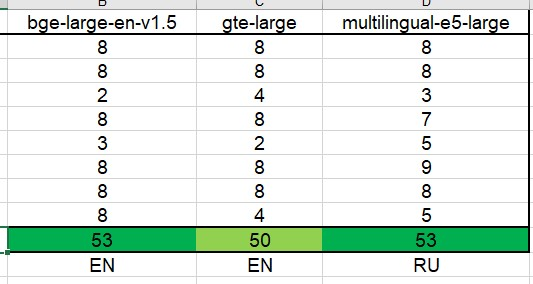